#Task 3: Predict high-demand job roles by analyzing job posting patterns over time

In [ ]:
import pandas as pd

In [ ]:
Jobs_data1=pd.read_csv('Jobs_data.csv')

In [ ]:
Jobs_data1.head(2)

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country,keywords,category,year_month
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,15.0,30.0,500.0,Other,"['experienced', 'medium', 'buyer', 'solar', 'p...",Other,2024-02
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,15.0,30.0,1100.0,United States,"['full', 'stack', 'developer']",Software Development,2024-02


In [ ]:
Jobs_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244827 entries, 0 to 244826
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244827 non-null  object 
 3   is_hourly       244827 non-null  bool   
 4   hourly_low      244827 non-null  float64
 5   hourly_high     244827 non-null  float64
 6   budget          244827 non-null  float64
 7   country         244827 non-null  object 
 8   keywords        244827 non-null  object 
 9   category        244827 non-null  object 
 10  year_month      244827 non-null  object 
dtypes: bool(1), float64(3), object(7)
memory usage: 18.9+ MB


In [ ]:
Jobs_data=Jobs_data1.copy()

In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

#Define Features, Target, and Data Preprocessing Pipeline

In [ ]:
# Define features and target
Jobs_data['demand'] = Jobs_data.groupby('year_month')['title'].transform('count')
features = Jobs_data.drop(columns=['demand', 'published_date', 'year_month', 'link'])
target = Jobs_data['demand']

# Separate numerical and categorical features
numerical_features = ['hourly_low', 'hourly_high', 'budget']
categorical_features = ['title', 'country', 'keywords', 'category', 'is_hourly']



# Create a ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0.3  # Use sparse output if the resulting matrix has more than 30% zeros
)

# Create Preprocessing Pipeline with TruncatedSVD for Dimensionality Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Create a pipeline to include TruncatedSVD
svd = TruncatedSVD(n_components=100)  # Adjust the number of components based on the desired explained variance

# Preprocessing pipeline including TruncatedSVD
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', svd)
])

# Preprocess the features
X_preprocessed = preprocessing_pipeline.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, target, test_size=0.2, random_state=42)

#Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Initialize the model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
print(f'Mean Absolute Error with Gradient Boosting: {mae_gb}')

Mean Absolute Error with Gradient Boosting: 19819.870144145883


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE)
mse_gb = mean_squared_error(y_test, y_pred_gb)

# Calculate R-squared (R2)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Mean Absolute Error with Gradient Boosting: {mae_gb}')
print(f'Mean Squared Error with Gradient Boosting: {mse_gb}')
print(f'R-squared with Gradient Boosting: {r2_gb}')

Mean Absolute Error with Gradient Boosting: 19819.870144145883
Mean Squared Error with Gradient Boosting: 407012145.8711112
R-squared with Gradient Boosting: 0.005834652398319817


In [ ]:
Jobs_data['published_date'] = pd.to_datetime(Jobs_data['published_date'])

# Extract year and month
Jobs_data['year_month'] = Jobs_data['published_date'].dt.to_period('M')

# Count job postings per category per month
Jobs_category_trends = Jobs_data.groupby(['title', 'year_month']).size().unstack(fill_value=0)

# Identify emerging categories based on posting frequency
emerging_categories = Jobs_category_trends.diff(axis=1).mean(axis=1).sort_values(ascending=False)
print(emerging_categories.head(10))

<ipython-input-42-fa0e9223ecf1>:4: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



title
Social Media Manager    61.25
Video Editor            50.50
Logo Design             50.25
Graphic Designer        43.00
Virtual Assistant       41.50
Logo design             25.00
Logo Designer           22.00
Lead Generation         20.75
Full Stack Developer    20.00
Appointment Setter      18.00
dtype: float64


<ipython-input-43-95a1d8c5403f>:4: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



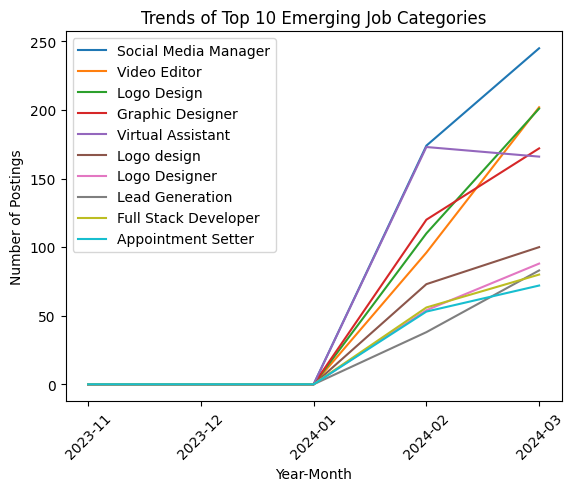

In [ ]:
import matplotlib.pyplot as plt

# Convert 'year_month' to strings
Jobs_data['year_month'] = Jobs_data['published_date'].dt.to_period('M').astype(str)

# Plot the trends for the top 10 emerging categories
top_emerging_categories = emerging_categories.head(10)
for category in top_emerging_categories.index:
    plt.plot(Jobs_category_trends.loc[category].index.astype(str), Jobs_category_trends.loc[category], label=category)

plt.title('Trends of Top 10 Emerging Job Categories')
plt.xlabel('Year-Month')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#Prepare Time Series Data for Job Postings by Category

In [ ]:
# Convert the 'year_month' column to datetime
Jobs_data['year_month'] = pd.to_datetime(Jobs_data['year_month'])

# Group by date and category, and count the number of postings
time_series_data = Jobs_data.groupby(['year_month', 'category']).size().unstack().fillna(0)

# Display the prepared data
print(time_series_data.head())

category    Administration  Construction  Consulting  Customer Service  \
year_month                                                               
2023-11-01             0.0           0.0         0.0               0.0   
2023-12-01             0.0           0.0         0.0               0.0   
2024-01-01             0.0           0.0         0.0               6.0   
2024-02-01           273.0           1.0       518.0             530.0   
2024-03-01           386.0           6.0       728.0             761.0   

category    Data Science  Design  Education  Engineering  Finance  Healthcare  \
year_month                                                                      
2023-11-01           0.0     0.0        0.0          0.0      0.0         0.0   
2023-12-01           0.0     0.0        0.0          0.0      0.0         0.0   
2024-01-01           1.0     3.0        0.0          1.0      3.0         1.0   
2024-02-01         408.0  5787.0      520.0       1128.0    601.0       194.

#Forecasting Job Postings for Category Using Simple Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Select the 'Data Science' category
category = 'Data Science'

# Check the number of data points
data_length = len(time_series_data[category])
print(f"Data points for {category}: {data_length}")

# Initialize the model
model = SimpleExpSmoothing(time_series_data[category])

# Fit the model
fit = model.fit()

# Forecast the next 12 months
forecast = fit.forecast(12)

# Display the forecasted values
print(forecast)

# Define the training and testing data (using all available data for training due to limited data points)
train = time_series_data[category]
test = time_series_data[category][-5:]  # Last 5 points as "test"

# Refit the model on training data
fit = model.fit()

# Forecast for the test period (here, using the same training period since we have limited data)
forecast_test = fit.forecast(len(test))

# Calculate the Mean Squared Error
mse = mean_squared_error(test, forecast_test)
print(f'Mean Squared Error: {mse}')

Data points for Data Science: 5
2024-04-01    500.524825
2024-05-01    500.524825
2024-06-01    500.524825
2024-07-01    500.524825
2024-08-01    500.524825
2024-09-01    500.524825
2024-10-01    500.524825
2024-11-01    500.524825
2024-12-01    500.524825
2025-01-01    500.524825
2025-02-01    500.524825
2025-03-01    500.524825
Freq: MS, dtype: float64
Mean Squared Error: 151827.2640616494


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



#Visualizing Actual vs. Forecasted Job Postings for 'Data Science' Categor

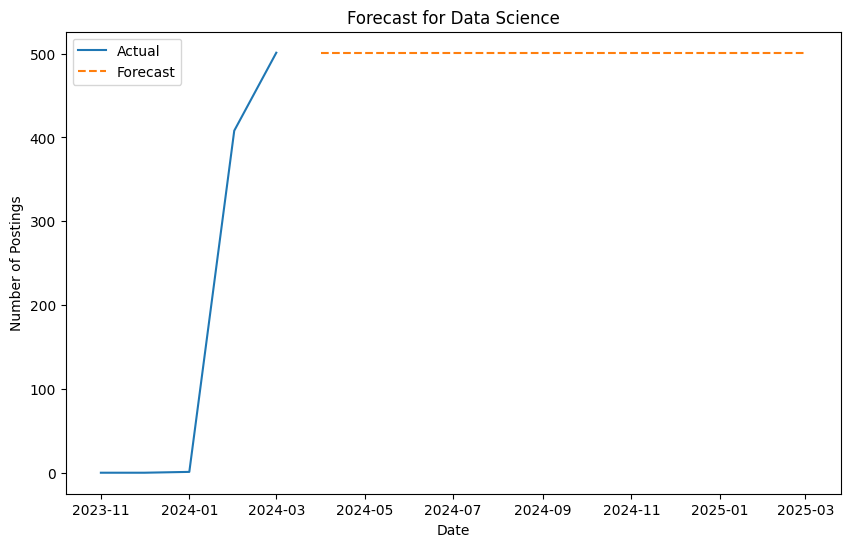

In [ ]:
# Plot actual vs. forecast
plt.figure(figsize=(10, 6))
plt.plot(time_series_data[category], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title(f'Forecast for {category}')
plt.xlabel('Date')
plt.ylabel('Number of Postings')
plt.show()

# Forecasting Job Posting Trends by Category

Data points for Administration: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



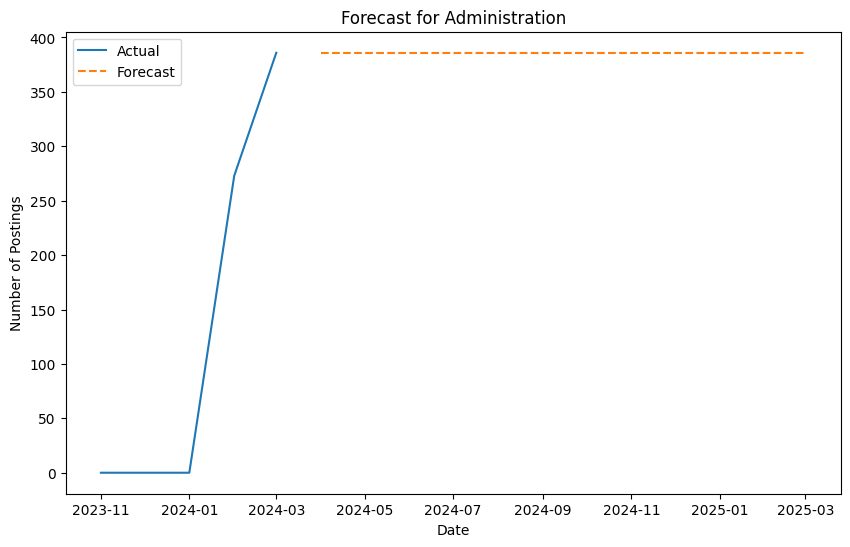

Data points for Construction: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



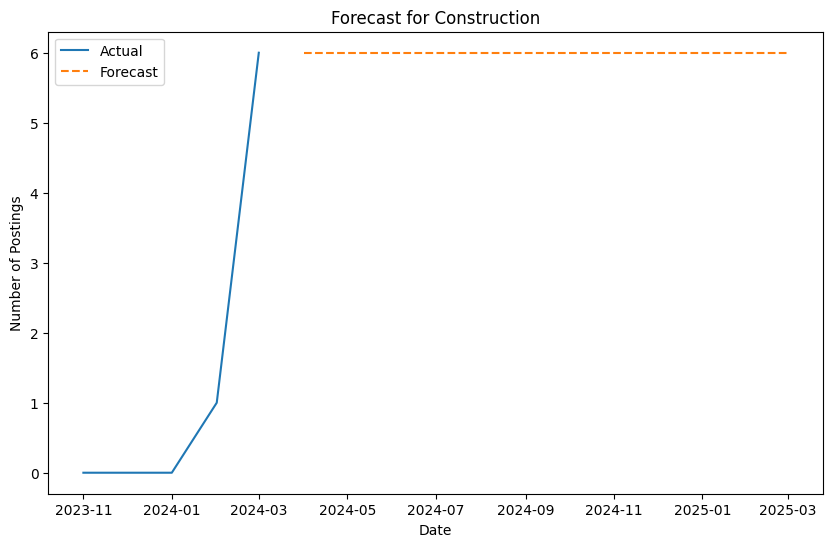

Data points for Consulting: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



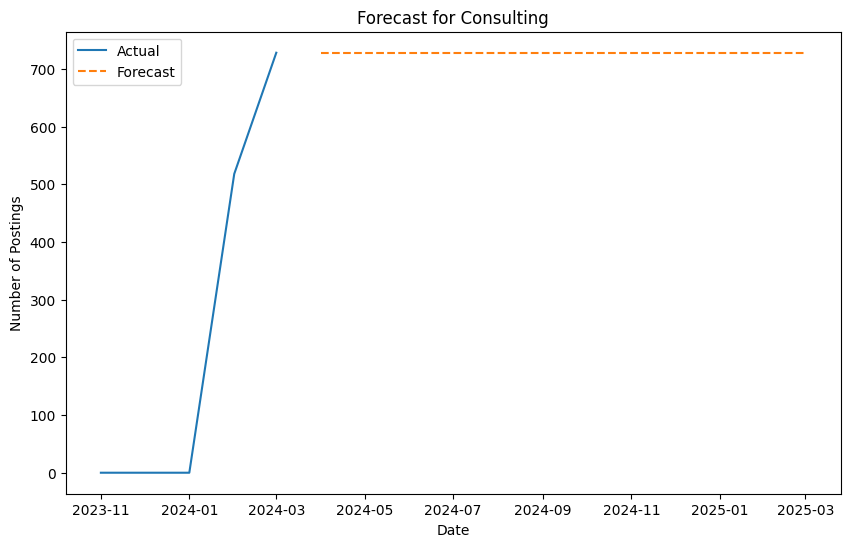

Data points for Customer Service: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



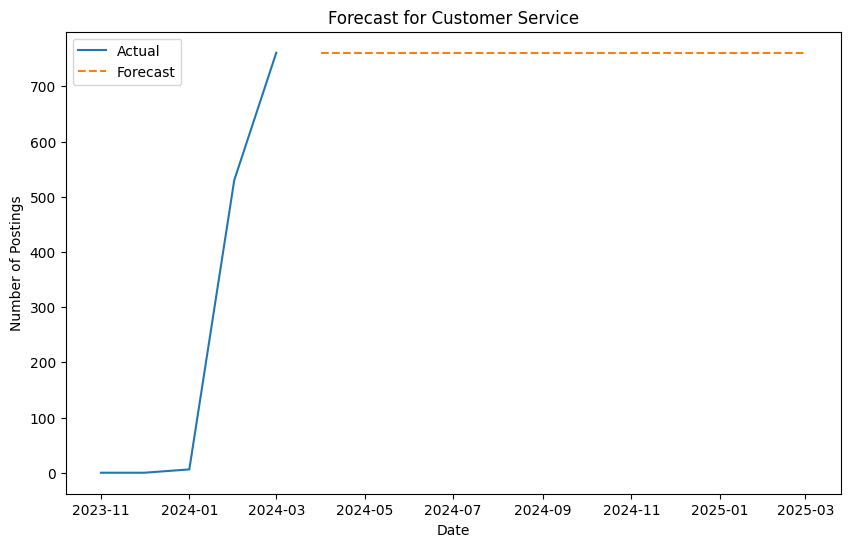

Data points for Data Science: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



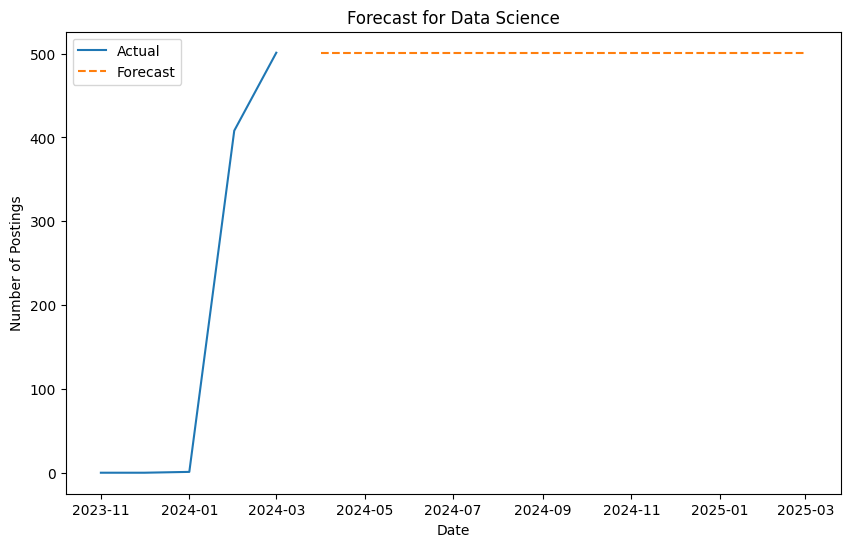

Data points for Design: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



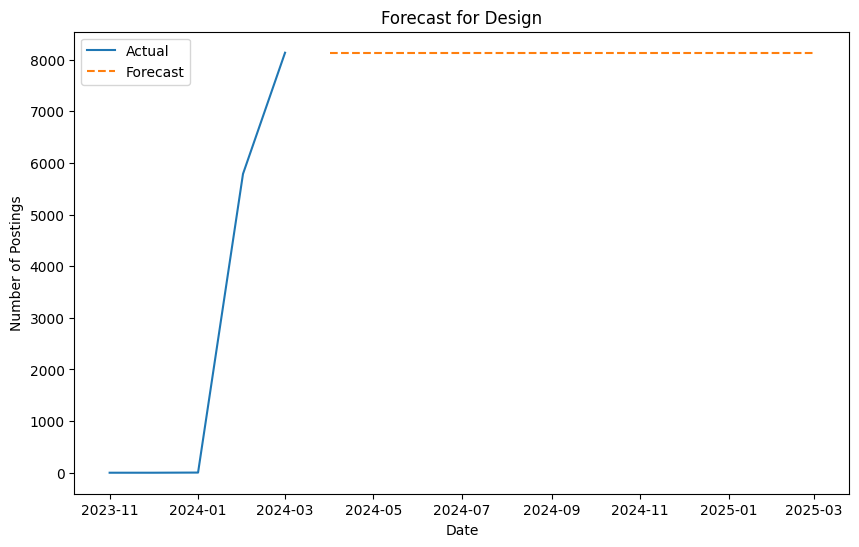

Data points for Education: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



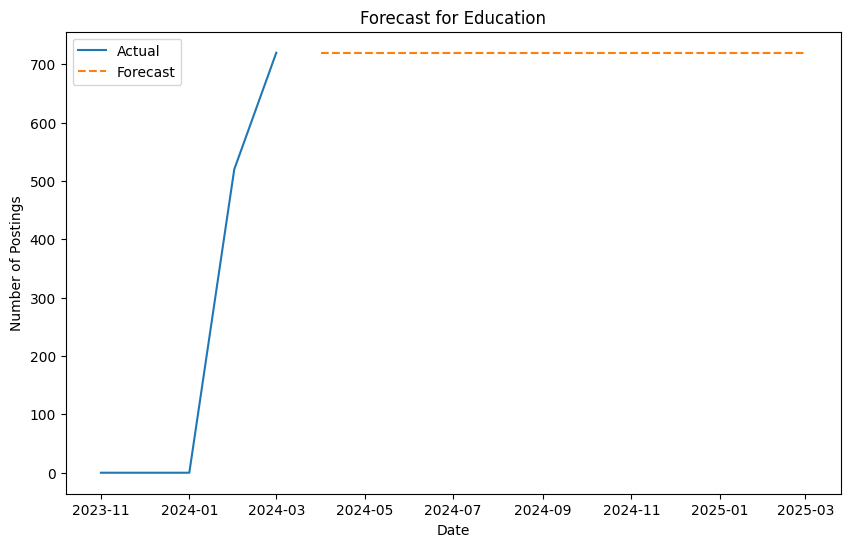

Data points for Engineering: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



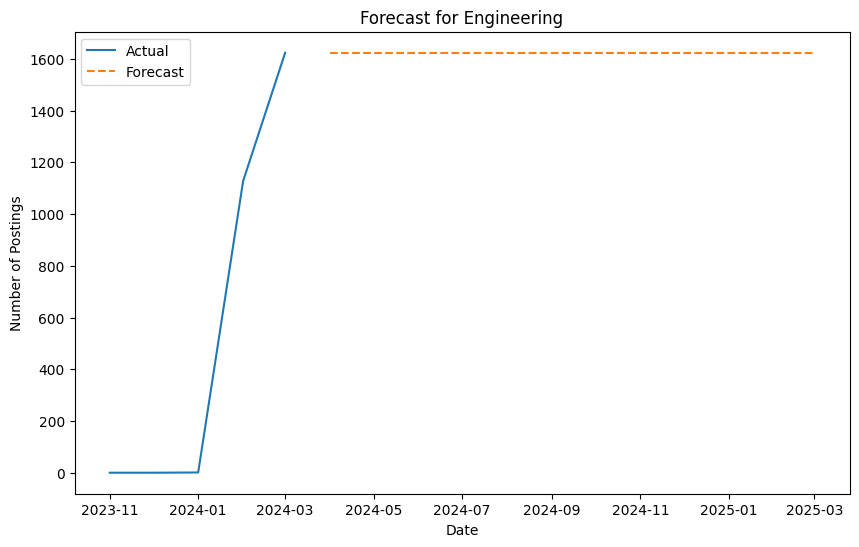

Data points for Finance: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



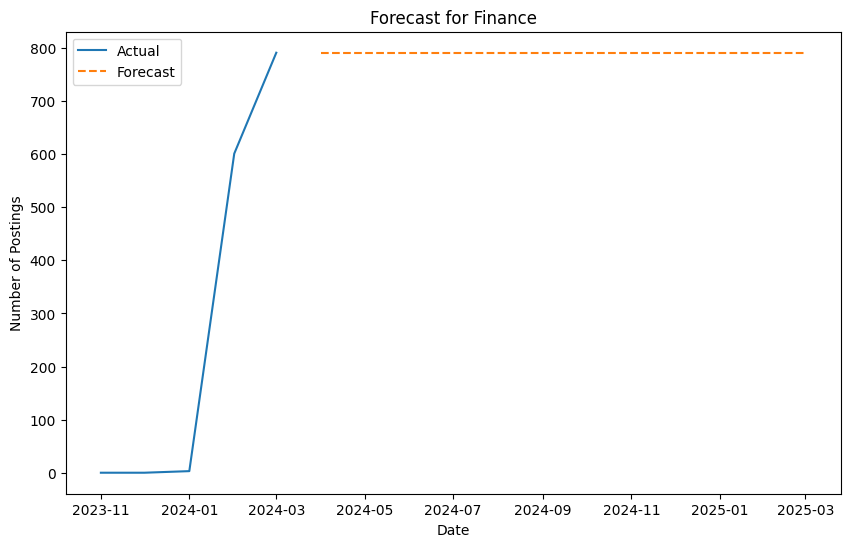

Data points for Healthcare: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



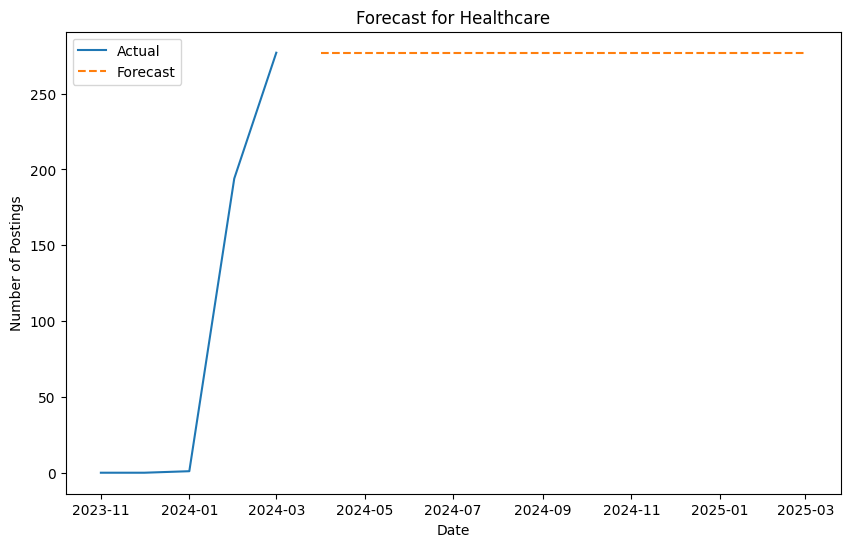

Data points for Hospitality: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



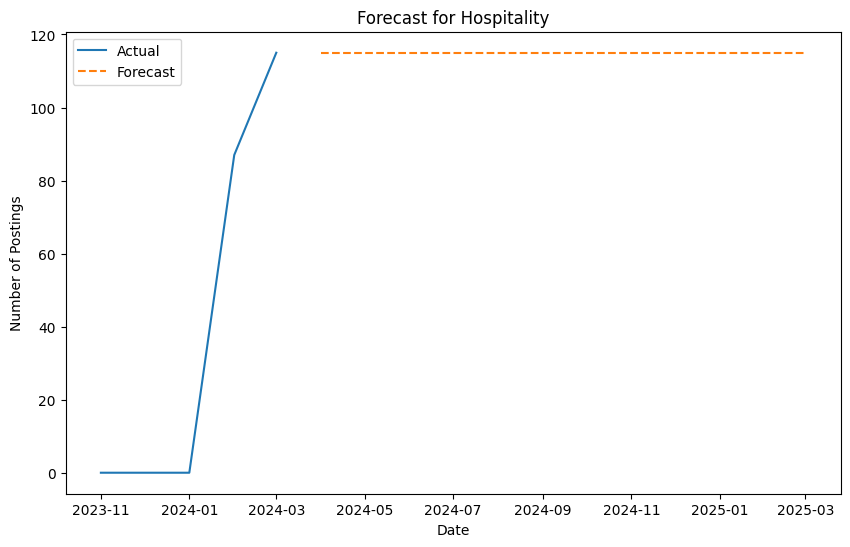

Data points for Human Resources: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



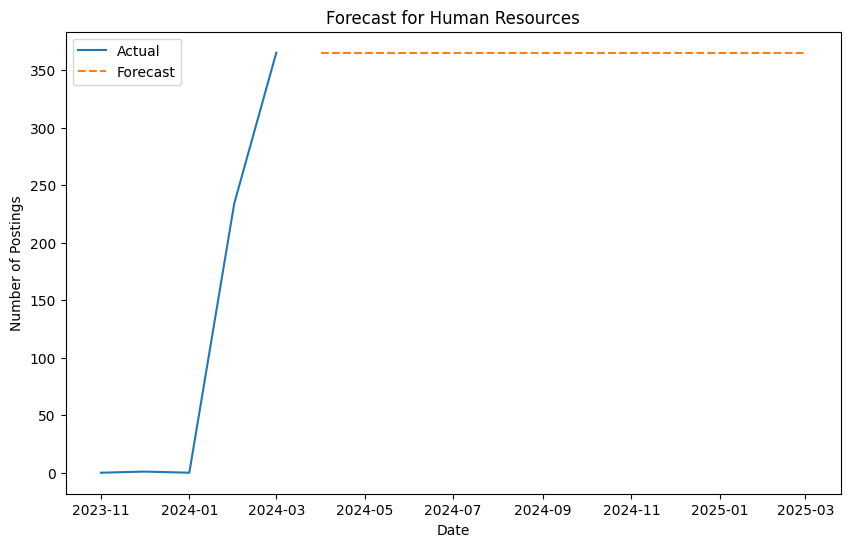

Data points for IT Support: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



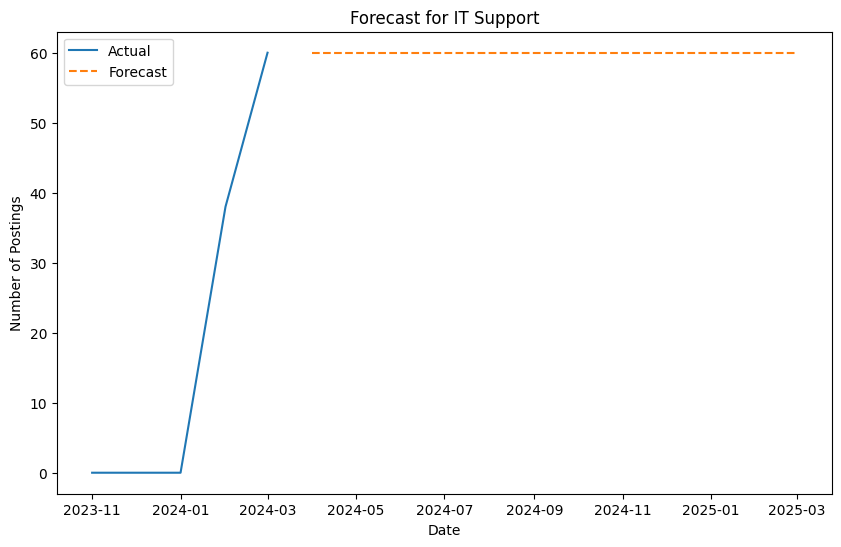

Data points for Legal: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



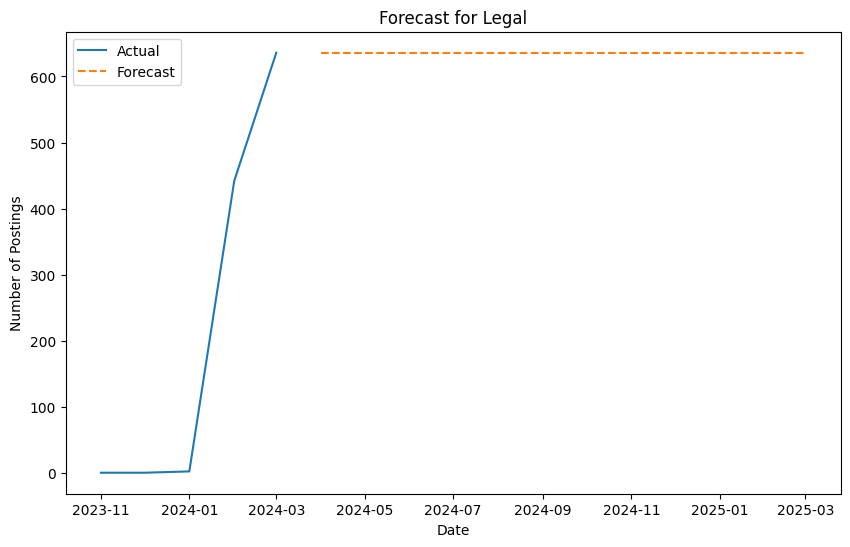

Data points for Manufacturing: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



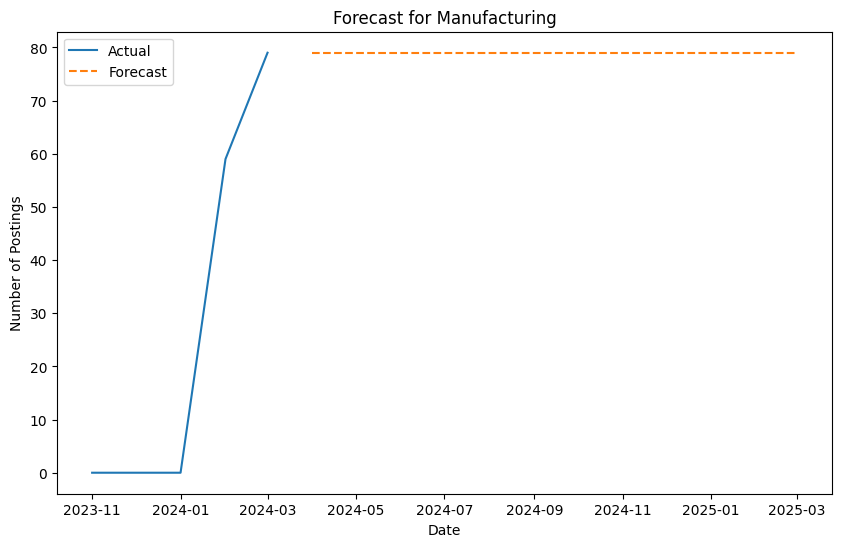

Data points for Marketing: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



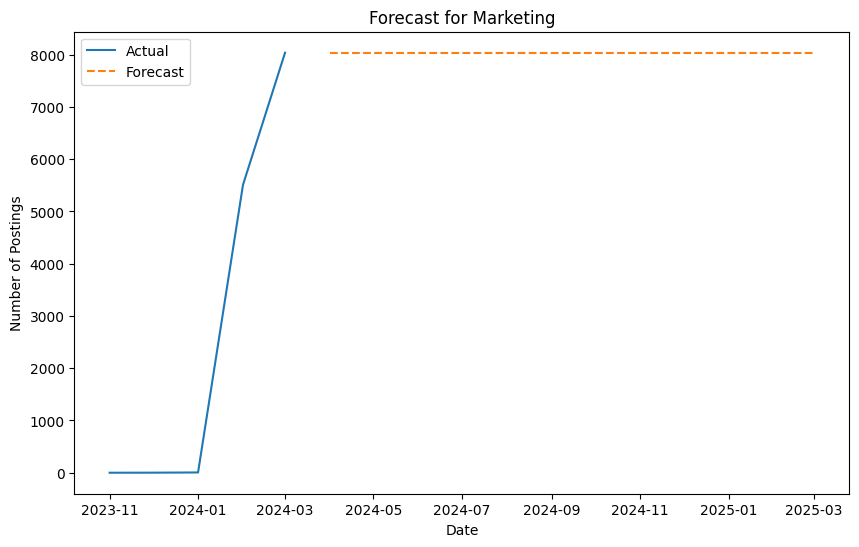

Data points for Operations: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



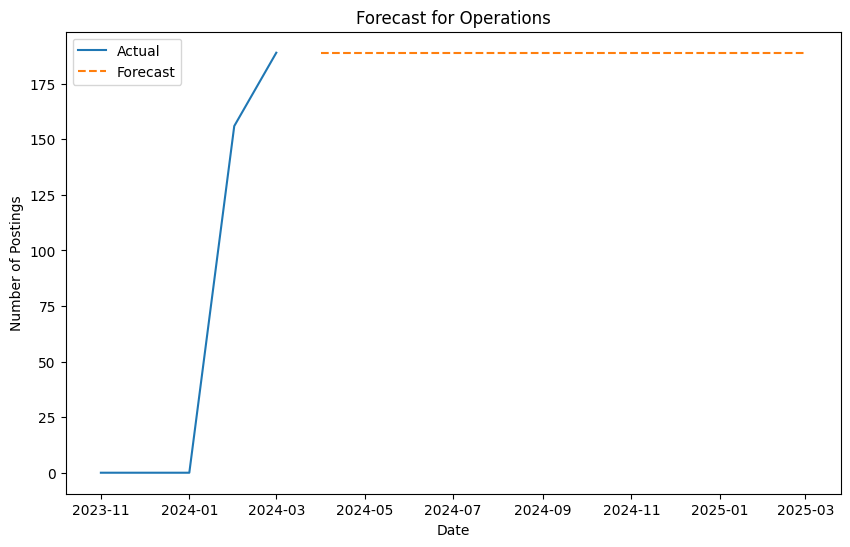

Data points for Other: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



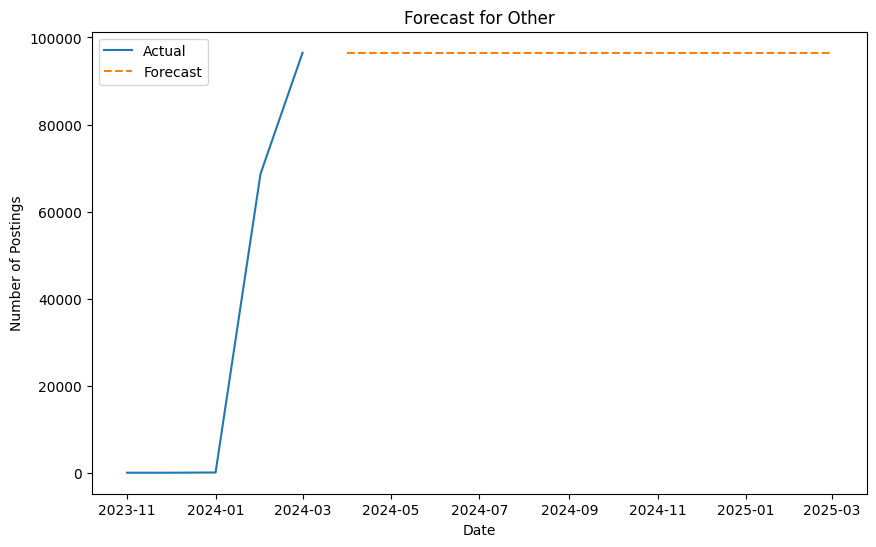

Data points for Product Management: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



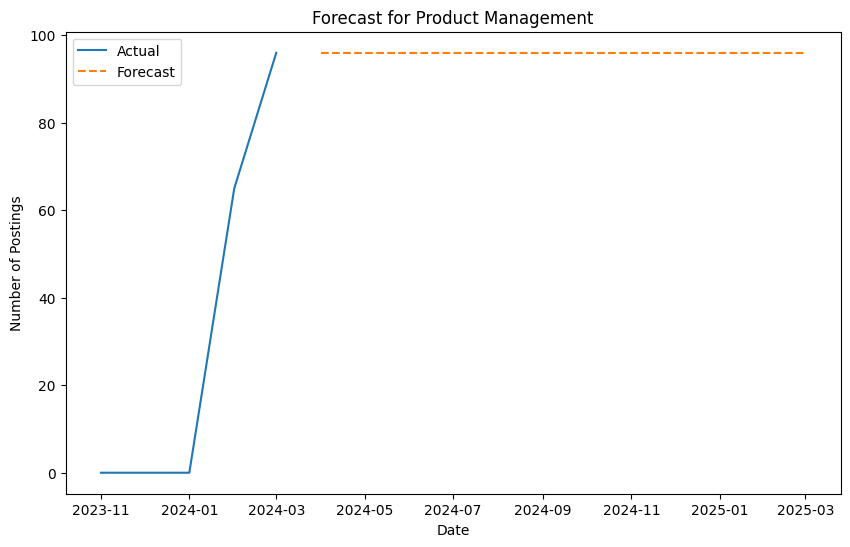

Data points for Project Management: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



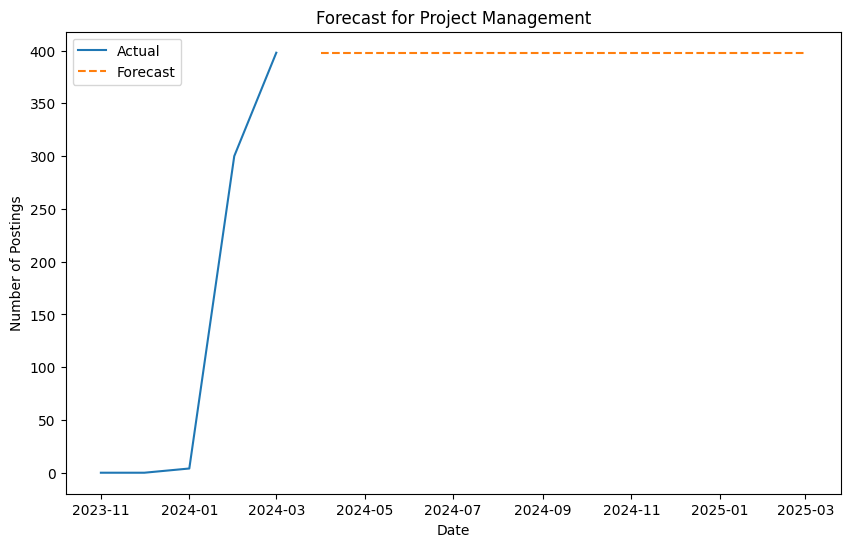

Data points for Real Estate: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



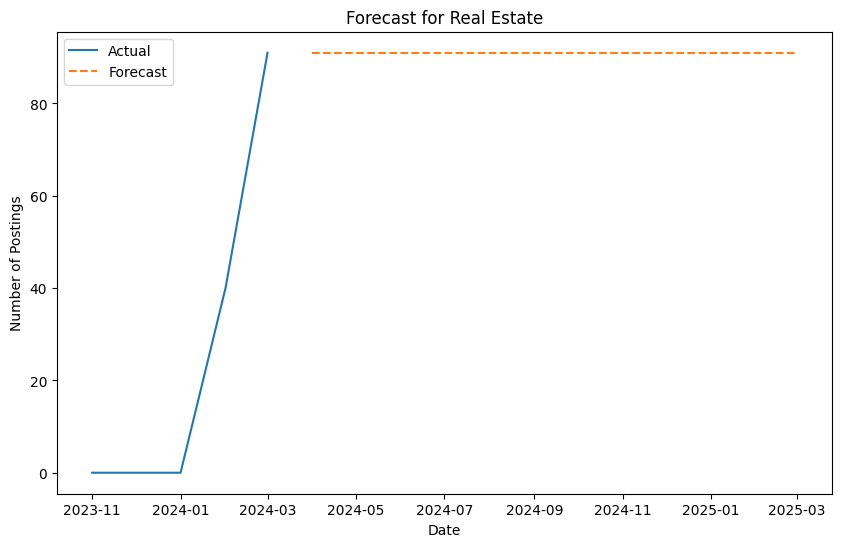

Data points for Research: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



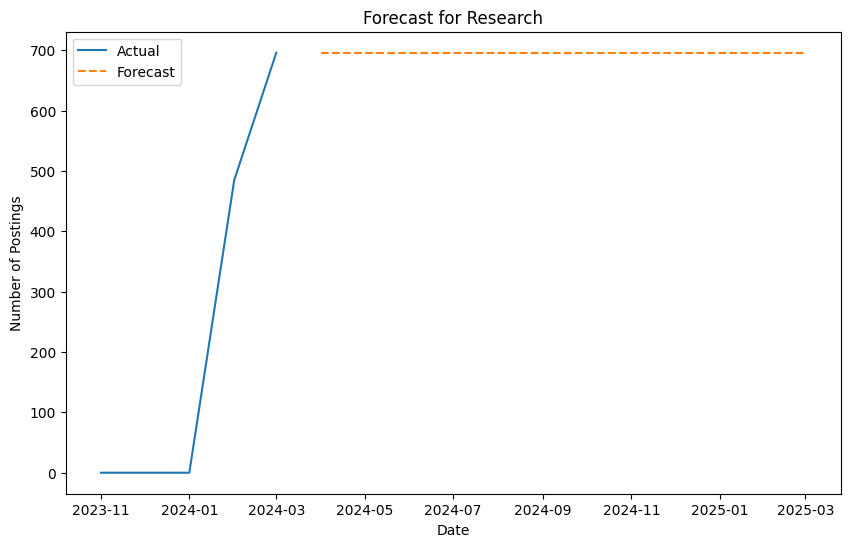

Data points for Retail: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



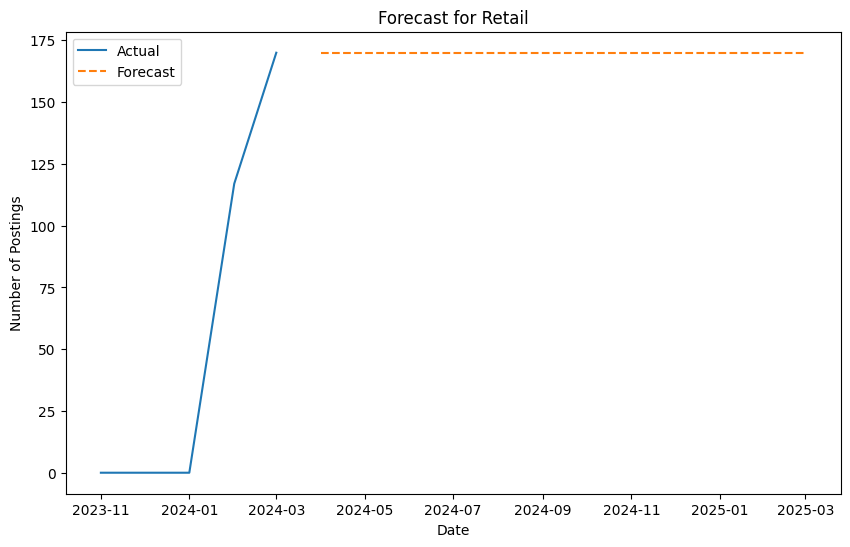

Data points for Sales: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



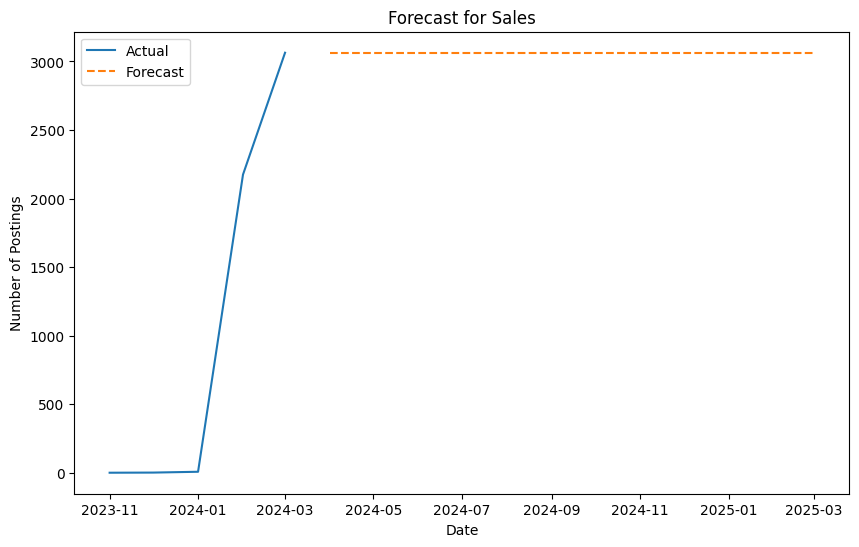

Data points for Software Development: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



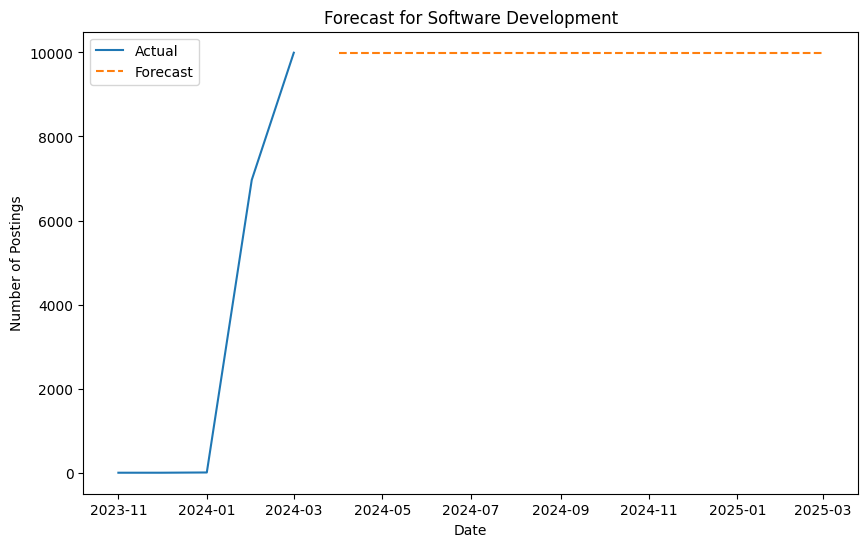

Data points for Writing and Editing: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



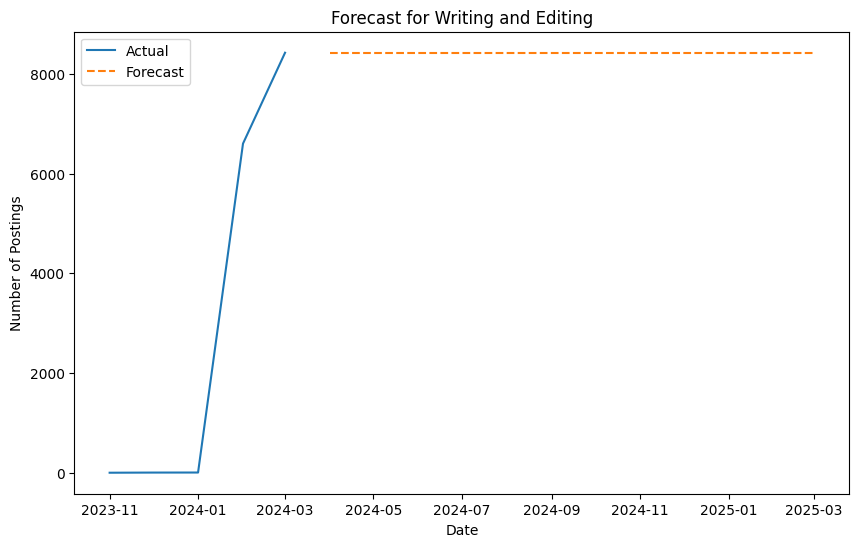

                Category           MSE
1           Construction  2.660000e+01
12            IT Support  2.256800e+03
14         Manufacturing  3.824600e+03
20           Real Estate  5.488800e+03
18    Product Management  5.721800e+03
10           Hospitality  8.091800e+03
22                Retail  1.790180e+04
16            Operations  2.165040e+04
9             Healthcare  4.730460e+04
11       Human Resources  8.289802e+04
0         Administration  9.166101e+04
19    Project Management  9.607359e+04
4           Data Science  1.518273e+05
13                 Legal  2.488937e+05
21              Research  2.985736e+05
6              Education  3.190400e+05
2             Consulting  3.268104e+05
3       Customer Service  3.551551e+05
8                Finance  3.806940e+05
7            Engineering  1.625601e+06
23                 Sales  5.781127e+06
15             Marketing  4.000424e+07
5                 Design  4.078910e+07
25   Writing and Editing  4.312898e+07
24  Software Development 

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Initialize a dictionary to store MSE for each category
mse_dict = {}

# Loop through each category and perform forecasting
for category in time_series_data.columns:
    # Check the length of the data
    data_length = len(time_series_data[category])
    print(f"Data points for {category}: {data_length}")

    # Use Simple Exponential Smoothing due to limited data points
    model = SimpleExpSmoothing(time_series_data[category])

    # Fit the model
    fit = model.fit()

    # Forecast the next 12 months
    forecast = fit.forecast(12)

    # Define the training and testing data (using all available data for training)
    train = time_series_data[category]
    test = time_series_data[category][-5:]  # Last 5 points as "test"

    # Refit the model on training data
    fit = model.fit()

    # Forecast for the test period (here, using the same training period since we have limited data)
    forecast_test = fit.forecast(len(test))

    # Calculate the Mean Squared Error
    mse = mean_squared_error(test, forecast_test)
    mse_dict[category] = mse

    # Plot actual vs. forecast
    plt.figure(figsize=(10, 6))
    plt.plot(time_series_data[category], label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
    plt.legend()
    plt.title(f'Forecast for {category}')
    plt.xlabel('Date')
    plt.ylabel('Number of Postings')
    plt.show()

# Display the MSE for each category
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['Category', 'MSE']).sort_values(by='MSE')
print(mse_df)

#Task 4: Compare average hourly rates across different countries

In [ ]:
import pandas as pd
import plotly.express as px

# Filter out non-hourly jobs
hourly_jobs = Jobs_data[Jobs_data['is_hourly'] == True].copy()

# Calculate the average hourly rate
hourly_jobs.loc[:, 'average_hourly_rate'] = hourly_jobs[['hourly_low', 'hourly_high']].mean(axis=1)

# Drop rows with missing country or average hourly rate
hourly_jobs = hourly_jobs.dropna(subset=['country', 'average_hourly_rate'])

# Calculate average hourly rate by country
country_hourly_rates = hourly_jobs.groupby('country')['average_hourly_rate'].mean().reset_index()

# Rename columns for clarity
country_hourly_rates.columns = ['country', 'avg_hourly_rate']

# Define a custom color scale
custom_color_scale = [
    (0.0, "rgb(165,0,38)"),   # Dark red
    (0.2, "rgb(215,48,39)"),  # Red
    (0.4, "rgb(244,109,67)"), # Orange
    (0.6, "rgb(253,174,97)"), # Light orange
    (0.8, "rgb(254,224,144)"),# Yellow
    (1.0, "rgb(255,255,191)") # Light yellow
]

# Create a choropleth map
fig = px.choropleth(
    country_hourly_rates,
    locations="country",
    locationmode='country names',
    color="avg_hourly_rate",
    hover_name="country",
    color_continuous_scale=custom_color_scale,
    title="Average Hourly Rates by Country"
)

# Update layout for better visuals and increased size
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    title=dict(x=0.5),
    width=1200,   # Set the width of the plot
    height=800    # Set the height of the plot
)

fig.show()


In [ ]:
import plotly.express as px

# Calculate average hourly rates by country
avg_hourly_rates = Jobs_data.groupby('country')['hourly_high'].mean().reset_index()

# Plot using Plotly
fig = px.choropleth(avg_hourly_rates, locations='country', locationmode='country names',
                    color='hourly_high', hover_name='country', title='Average Hourly Rates by Country')
fig.show()

In [ ]:
Jobs_data['description'] = Jobs_data['title'] + ' ' + Jobs_data['country']

Extracting Features from Job Descriptions Using TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(Jobs_data['description'])

# Building a Nearest Neighbors Model with Cosine Similarity for Job Descriptions

In [ ]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(X)

NearestNeighbors(algorithm='brute', metric='cosine')

# Persisting Job Recommender Model and Vectorizer Using Pickle

In [ ]:
import pickle

with open('job_recommender_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer,f)

In [ ]:
Jobs_data['country'].unique()

array(['Other', 'United States', 'India', 'Portugal', 'Germany', 'Canada',
       'Singapore', 'United Kingdom', 'Denmark', 'Malaysia', 'Bangladesh',
       'Saudi Arabia', 'Australia', 'Ukraine', 'Pakistan', 'Nigeria',
       'Peru', 'Costa Rica', 'Switzerland', 'France', 'China', 'Israel',
       'Hong Kong', 'Serbia', 'Bahrain', 'Thailand', 'Spain', 'Croatia',
       'Luxembourg', 'Kenya', 'Finland', 'Bulgaria', 'Georgia',
       'New Zealand', 'Lebanon', 'Uzbekistan', 'Palestinian Territories',
       'Italy', 'Egypt', 'Albania', 'Netherlands', 'Mexico', 'Azerbaijan',
       'Norway', 'Sweden', 'Czech Republic', 'United Arab Emirates',
       'Uganda', 'South Africa', 'Honduras', 'Argentina', 'Belgium',
       'Cyprus', 'Ecuador', 'Philippines', 'Puerto Rico', 'Holy See',
       'Greece', 'Brazil', 'Morocco', 'Estonia', 'Poland', 'Iceland',
       'Indonesia', 'Kuwait', 'Ireland', 'Panama', 'Jordan', 'Qatar',
       'Tanzania', 'Turkey', 'Slovakia',
       'Micronesia, Federated St